In [1]:
from langchain_groq import ChatGroq
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
import operator
load_dotenv()


c:\Users\ketan\Desktop\Daily\LangChain\LangYou\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
class EvalatinSchama(BaseModel):
    feedback: str = Field(description="For the following text provide Detailed feedback")
    score: int = Field(description="Provide Score for given Text n betwween 0 to 10 ", gt=0,lt=11)

In [4]:
structured_model = model.with_structured_output(EvalatinSchama)

In [5]:
class UPSEState(TypedDict):
    eassy : str
    language_feedbake: str
    analysis_feedback : str
    clarity_feedback : str
    overall_feedback : str
    score : Annotated[list[int],operator.add]

In [6]:
essay = "Trees are one of the most valuable gifts of nature to humanity. They play a vital role in maintaining the balance of our environment and sustaining life on Earth. Without trees, life as we know it would not be possible. First and foremost, trees produce oxygen, which is essential for the survival of all living beings. They absorb carbon dioxide and other harmful gases, thereby purifying the air we breathe. Trees also help in controlling the temperature of our surroundings by providing shade and releasing water vapor through transpiration. Moreover, trees prevent soil erosion by holding the soil firmly with their roots. They also help in reducing floods by absorbing excess rainwater. Forests, which are large groups of trees, provide homes to countless species of animals, birds, and insects, helping maintain biodiversity. In addition to their environmental benefits, trees have great economic and social importance. They provide us with fruits, timber, medicines, and many other useful products. Green spaces filled with trees also make our cities more beautiful and peaceful, improving mental well-being. In conclusion, trees are the lifelines of our planet. It is our duty to protect and plant more trees to ensure a greener and healthier future. As the saying goes, “The best time to plant a tree was 20 years ago. The second-best time is now.”"


In [7]:
def language_feedbake(state : UPSEState):
    prompt = f"Provide language_feedback and score for {essay} "
    result = structured_model.invoke(prompt)

    return {'language_feedbake': result.feedback, 'score':[result.score]}

In [8]:
def analysis_feedback(state : UPSEState):
    prompt = f"Provide analysis_feedback and score for {essay} "
    result = structured_model.invoke(prompt)

    return {'analysis_feedback': result.feedback, 'score':[result.score]}

In [9]:
def overall_feedback(state : UPSEState):
    prompt = f"Provide overall_feedback and score for {state['analysis_feedback']} and {state['clarity_feedback']} and {state['language_feedbake']} "
    result = structured_model.invoke(prompt)
    avg = sum(state['score'])/len(state['score'])
    return {'overall_feedback': result.feedback, 'score':[avg]}

In [10]:
def clarity_feedback(state: UPSEState):
    prompt = f"Provide clarity_feedback and score for {essay} "
    result = structured_model.invoke(prompt)

    return {'clarity_feedback': result.feedback, 'score':[result.score]}

In [11]:
graph = StateGraph(UPSEState)

graph.add_node("language_feedbake", language_feedbake)
graph.add_node("analysis_feedback", analysis_feedback)
graph.add_node("clarity_feedback",clarity_feedback)
# Add missing node definition for overall_feedback
graph.add_node("overall_feedback", overall_feedback)

graph.add_edge(START, 'language_feedbake')
graph.add_edge(START, 'clarity_feedback')
graph.add_edge(START, 'analysis_feedback')

graph.add_edge('language_feedbake', 'overall_feedback')
graph.add_edge('clarity_feedback', 'overall_feedback')
graph.add_edge('analysis_feedback', 'overall_feedback')

graph.add_edge('overall_feedback', END)
compiled = graph.compile()

In [12]:
result = compiled.invoke({'essay': essay})
print('language_feedback:', result.get('language_feedbake'))
print('clarity_feedback:', result.get('clarity_feedback'))
print('analysis_feedback:', result.get('analysis_feedback'))
print('overall_feedback:', result.get('overall_feedback'))
print('scores:', result.get('score'))

language_feedback: The text provides a clear and well-structured argument about the importance of trees, highlighting their environmental, economic, and social benefits. The use of transitional phrases and cohesive language makes the text easy to follow. However, some sentences are wordy and could be condensed for better clarity. Additionally, the text could benefit from more specific examples and data to support the claims. The conclusion effectively summarizes the main points and ends with a thought-provoking quote, leaving the reader with a lasting impression. Overall, the text demonstrates a good understanding of the topic and effective use of language.
clarity_feedback: The text provides a clear and detailed explanation of the importance of trees in maintaining the balance of the environment and sustaining life on Earth. The writer effectively highlights the various benefits of trees, including their role in producing oxygen, controlling temperature, preventing soil erosion, and p

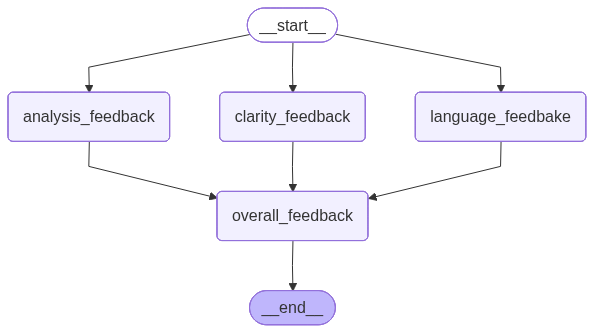

In [13]:
compiled